In [2]:
import os
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from enum import Enum
import json
from tqdm import tqdm

tqdm.pandas()

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision.transforms import Resize

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
datasetRoot = "./"

In [4]:
def log2(x):
    return int(math.log2(x))

def plot_images(images, log2_res, fname=""):
    '''
    Helper function to plot a set of images
    '''
    scales = {2: 0.5, 3: 1, 4: 2, 5: 3, 6: 4, 7: 5, 8: 6, 9: 7, 10: 8}
    scale = scales[log2_res]

    grid_col = min(images.shape[0], int(32 // scale))
    grid_row = 1

    f, axarr = plt.subplots(
        grid_row, grid_col, figsize=(grid_col * scale, grid_row * scale)
    )

    for row in range(grid_row):
        ax = axarr if grid_row == 1 else axarr[row]
        for col in range(grid_col):
            ax[col].imshow(images[row * grid_col + col])
            ax[col].axis("off")
    plt.show()
    if fname:
        f.savefig(fname)


In [5]:
def process_filepath(x):
    x = x.split("/")
    x.pop(1)
    return "/".join(x)

data = pd.read_json(os.path.join(datasetRoot,"ffhq-dataset-v2.json"),orient="index")
data['image_path'] = data.progress_apply(lambda x : process_filepath(x['thumbnail']['file_path']),axis=1)
data = data.drop(columns=['image','thumbnail','in_the_wild','metadata'])

train_data = data.loc[data['category']=='training'].drop(columns=['category'])
validation_data = data.loc[data['category']=='validation'].drop(columns=['category']).reset_index().drop(columns=['index'])

100%|██████████| 70000/70000 [00:00<00:00, 170878.14it/s]


In [6]:
class FFHQDataset(Dataset):
    """ Dataset to load FFHQ data from a dataframe

    Args:

        dataframe : dataframe with image paths in column 'image_path'
        datasetRoot : the root path to join before the image_path, if any.
        res : resolution of the image generated
    
    """
    def __init__(self, dataframe, datasetRoot, res = 2) -> None:
        super().__init__()
        self.dataframe = dataframe
        self.datasetRoot = datasetRoot
        self.res = res
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, index) :
        img_path = os.path.join(self.datasetRoot,self.dataframe['image_path'].iloc[index])
        image = read_image(img_path)
        return Resize((self.res,self.res))(image)


In [7]:
train_dataset = FFHQDataset(train_data,datasetRoot)
validation_dataset = FFHQDataset(validation_data,datasetRoot)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=64, shuffle=True)


Feature batch shape: torch.Size([64, 3, 2, 2])


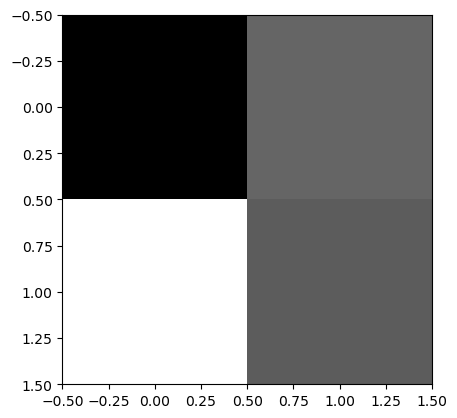

In [8]:
train_features = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
img = train_features[0][1]
plt.imshow(img, cmap="gray")
plt.show()

In [9]:
def fade_in(alpha, a, b):
    '''
    Smoothing function
    '''
    return alpha * a + (1- alpha ) * b

def wasserstein_loss(y_true, y_pred):
    '''
    Wasserstein Loss ( Refer to WGANs)
    '''
    return - (y_true * y_pred).mean()

def pixel_norm(x, epsilon = 1e-8):
    return x / torch.sqrt(torch.mean(x**2, dim = -1, keepdim=True)+ epsilon)

def minibatch_std(x, eps=1e-8):
    """Compute the mini-batch standard deviation of input tensor x.
        ref : <https://arxiv.org/pdf/1710.10196.pdf>
    """
    batch_size, num_channels, height, width = x.size()
    if batch_size < 2:
        return torch.zeros(1, num_channels, 1, 1).to(x.device)
    mean = torch.mean(x, dim=0, keepdim=True)
    var = torch.mean(torch.pow(x - mean, 2), dim=0, keepdim=True)
    std = torch.sqrt(var + eps)
    mean_std = torch.mean(std, dim=(1, 2, 3), keepdim=True)
    mean_std = mean_std.expand(batch_size, -1, height, width)
    return torch.cat([x, mean_std], dim=1)


class EqualisedConv2D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel = 3, gain = 2) -> None:
        super().__init__()

        self.w = nn.Parameter(torch.empty(out_channels, in_channels ,kernel, kernel).normal_(), requires_grad= True)
        self.b = nn.Parameter(torch.empty(out_channels).zero_() , requires_grad= True)

        fan_in = kernel * kernel * in_channels
        self.scale = math.sqrt(gain / fan_in)
    
    def forward(self, inputs):
        return F.conv2d(inputs, self.scale * self.w, self.b, padding='same' )


class EqualisedLinear(nn.Module):
    def __init__(self, dim_in, dim_out , gain = 2, lr_multiplier = 1) -> None:
        super().__init__()

        self.w = nn.Parameter(torch.empty(dim_out,dim_in).normal_(0.0, 1.0 / lr_multiplier), requires_grad= True)
        self.b = nn.Parameter(torch.empty(dim_out).zero_(),requires_grad=True)

        self.scale = math.sqrt(gain / dim_in)
        self.lr_multiplier = lr_multiplier
    
    def forward(self, inputs):
        return F.linear(inputs, self.scale * self.w, self.b) * self.lr_multiplier

class AddNoise(nn.Module):
    def __init__(self, x_shape) -> None:
        super().__init__()
        c , h, w = x_shape
        self.b = nn.Parameter(torch.empty([1,c,1,1]).normal_(),requires_grad=True)
    
    def forward(self, inputs):
        x, noise = inputs
        return  x + self.b * noise

class AdaIn(nn.Module):
    def __init__(self, w_channels, x_channels, gain =1) -> None:
        super().__init__()

        self.x_channels = x_channels

        self.dense_1 = EqualisedLinear(w_channels, x_channels, gain)
        self.dense_2 = EqualisedLinear(x_channels, x_channels, gain)
    
    def forward(self, inputs):
        x, w = inputs
        ys = self.dense_1(w).reshape((-1,self.x_channels,1,1))
        yb = self.dense_2(w).reshape((-1,self.x_channels,1,1))

        return ys * x + yb

In [10]:
class GeneratorBlock(nn.Module):
    def __init__(self, filter_num, res, input_shape, is_base) -> None:
        super().__init__()

        self.is_base = is_base

        # Needs AdaIn & AddNoise Layers
        if not is_base:
            self.up_sample = nn.Upsample(scale_factor=2)
            self.init_conv = EqualisedConv2D(input_shape[0], filter_num, 3)

        self.lrelu = nn.LeakyReLU(0.2)

        self.add_noise_1 = AddNoise(input_shape)
        self.instance_norm_1 = nn.InstanceNorm2d(input_shape[0])
        self.ada_in_1 = AdaIn(512, input_shape[0])
        self.conv_1 = EqualisedConv2D(input_shape[0], filter_num, 3)

        self.add_noise_2 = AddNoise(input_shape)
        self.instance_norm_2 = nn.InstanceNorm2d(input_shape[0])
        self.ada_in_2 = AdaIn(512, input_shape[0])
        self.conv_2 = EqualisedConv2D(input_shape[0], filter_num, 3)

    def forward(self, inputs):
        x, w, noise = inputs

        if not self.is_base:
            x = self.up_sample(x)
            x = self.init_conv(x)

        x = self.add_noise_1([x, noise])
        x = self.instance_norm_1(x)
        x = self.ada_in_1([x,w])
        x = self.conv_1(x)

        x = self.add_noise_2([x, noise])
        x = self.instance_norm_2(x)
        x = self.ada_in_2([x,w])
        x = self.conv_2(x)

        return x
    
#### TEST Generate BLOCK ####
# x = GeneratorBlock(512,4,[512,2,2],True)([torch.ones(24,512,2,2),torch.ones(24,512),torch.ones(1,2,2)])
# x = EqualisedConv2D(512,3,1,gain = 1)(x)
# x.shape


In [11]:
class DiscriminatorBlock(nn.Module):
    def __init__(self, filter_num_1, filter_num_2, res, is_base = False) -> None:
        super().__init__()

        self.is_base = is_base
        self.leakyRelu = nn.LeakyReLU(0.2)


        if not is_base:
            self.conv_1 = EqualisedConv2D(filter_num_1,filter_num_1,3)
            self.conv_2 = EqualisedConv2D(filter_num_1,filter_num_2)
            self.avg_pool = nn.AvgPool2d((2,2))
        else:
            self.conv_1 = EqualisedConv2D(filter_num_1+1,filter_num_1,3)
            self.flatten = nn.Flatten()
            self.lin_1 = EqualisedLinear(res*res*filter_num_1,filter_num_1)
            self.lin_2 = EqualisedLinear(filter_num_1,1)
    
    def forward(self, inputs):
        # if not base, we don't flatten
        if not self.is_base:
            x = self.conv_1(inputs)
            x = self.leakyRelu(x)
            x = self.conv_2(x)
            x = self.leakyRelu(x)
            x = self.avg_pool(x)
            return x
        else:
        # if base, we flatten & pass through dense
            x = minibatch_std(inputs)
            x = self.conv_1(x)
            x = self.leakyRelu(x)
            x = self.flatten(x)
            x = self.lin_1(x)
            x = self.leakyRelu(x)
            x = self.lin_2(x)
            return x
        
#### TEST Dicriminator BLOCK ####
# DiscriminatorBlock(5,5,4,False)(torch.ones(24,5,4,4)).shape

In [12]:
class Generator(nn.Module):
    """
    Generator Module for the StyleGAN Generator
    """
    def __init__(self, start_res_log2, target_res_log2) -> None:
        super().__init__()

        self.start_res_log2 = start_res_log2
        self.target_res_log2 = target_res_log2
        self.num_stages = target_res_log2 - start_res_log2 +1

        self.curr_res_log2 = start_res_log2

        # generator Blocks
        self.g_blocks = []
        # one rgb block per genblock
        self.to_rgb = []

        self.filter_nums = {
            0: 512,
            1: 512,
            2: 512,  # 4x4
            3: 512,  # 8x8
            4: 512,  # 16x16
            5: 512,  # 32x32
            6: 256,  # 64x64
            7: 128,  # 128x128
            8: 64,  # 256x256
            9: 32,  # 512x512
            10: 16,
        }

        start_res = 2 ** start_res_log2
        self.input_shape = (self.filter_nums[start_res_log2], start_res, start_res)
        
        for i in range(start_res_log2, target_res_log2 + 1):
            filter_num = self.filter_nums[i]
            res = 2 ** i
            
            to_rgb = EqualisedConv2D(filter_num , 3, 1, gain=1)

            self.to_rgb.append(to_rgb)

            is_base = i == self.start_res_log2

            if is_base:
                input_shape = (self.filter_nums[i - 1], res, res)
            else:
                input_shape = (self.filter_nums[i - 1], 2 ** (i - 1), 2 ** (i - 1))
            
            g_block = GeneratorBlock(filter_num, res, input_shape, is_base)
            self.g_blocks.append(g_block)

        self.up_sample = nn.Upsample(scale_factor=2)
        self.g_blocks = nn.ModuleList(self.g_blocks)
        self.to_rgb = nn.ModuleList(self.to_rgb)
    
    def grow(self, res_log2):
        self.curr_res_log2 = res_log2

    def forward(self, inputs):
        g_input, w, noise_inputs, alpha = inputs

        """
        Shapes: 
            g_input -> self.filter_nums[start_res_log2], start_res, start_res
            w -> self.num_stages, 512
            noise_inputs -> self.num_stages, 1, res, res
            alpha -> 1
        """
        num_stages = self.curr_res_log2 - self.start_res_log2 +1

        x = self.g_blocks[0]([g_input, w[:,0],noise_inputs[0]])

        rgb = None
        if num_stages==1:
            rgb = self.to_rgb[0](x)
        else:
            for i in range(1,num_stages-1):
                x = self.g_blocks[i]([x,w[:,i],noise_inputs[i]])
            
            old_rgb = self.to_rgb[num_stages-1](x)
            old_rgb = self.up_sample(old_rgb)

            i = num_stages -1
            x = self.g_blocks[i]([x,w[:,i],noise_inputs[i]])

            new_rgb = self.to_rgb[i](x)

            rgb = fade_in(alpha[0],new_rgb, old_rgb)
        
        return rgb



In [13]:
class Discriminator(nn.Module):
    def __init__(self, start_res_log2, target_res_log2) -> None:
        super().__init__()

        self.start_res_log2 = start_res_log2
        self.target_res_log2 = target_res_log2
        self.curr_res_log2 = self.start_res_log2

        self.num_stages = target_res_log2 - start_res_log2 +1

        self.filter_nums = {
            0: 512,
            1: 512,
            2: 512,  # 4x4
            3: 512,  # 8x8
            4: 512,  # 16x16
            5: 512,  # 32x32
            6: 256,  # 64x64
            7: 128,  # 128x128
            8: 64,  # 256x256
            9: 32,  # 512x512
            10: 16,
        }

        self.d_blocks = []

        self.from_rgb = []

        for res_log2 in range(self.start_res_log2, self.target_res_log2 +1):
            res = 2**res_log2

            filter_num = self.filter_nums[res_log2]

            from_rgb = nn.Sequential(
                EqualisedConv2D(3,filter_num,1),
                nn.LeakyReLU(0.2)
            )

            self.from_rgb.append(from_rgb)

            d_block = DiscriminatorBlock(filter_num, self.filter_nums[res_log2-1],res,len(self.d_blocks)==0)
            self.d_blocks.append(d_block)
            
        self.avg_pool = nn.AvgPool2d((2,2))
        self.from_rgb = nn.ModuleList(self.from_rgb)
        self.d_blocks = nn.ModuleList(self.d_blocks)
    
    def grow(self, res_log2):
        self.curr_res_log2 = res_log2
    
    def forward(self, inputs):
        input_image, alpha = inputs

        res = 2 ** self.curr_res_log2 
        idx = self.curr_res_log2 - self.start_res_log2

        x = self.from_rgb[idx](input_image)
        x = self.d_blocks[idx](x)

        if idx >0 :
            idx -=1
            downsized_image = self.avg_pool(input_image)
            y = self.from_rgb[idx](downsized_image)
            x = fade_in(alpha[0],x,y)

            for i in range(idx, -1, -1):
                x = self.d_blocks[i](x)
        
        return x


In [14]:
class Mapping(nn.Module):
    def __init__(self, num_stages, input_shape = 512) -> None:
        super().__init__()
        
        self.input_shape = input_shape
        self.num_stages = num_stages

        self.layers = []
        for _ in range(8):
            self.layers.append(EqualisedLinear(input_shape, 512, 0.01))
            self.layers.append(nn.LeakyReLU(0.2))
        
        self.layers = nn.ModuleList(self.layers)

    def forward(self, input):
        x = pixel_norm(input)
        for layer in self.layers:
            x = layer(x)
        return torch.tile(torch.unsqueeze(x,1),(1,self.num_stages,1))

In [16]:
class Phase(Enum):
    TRANSITION = 1
    STABLE = 2

class OptimType(Enum):
    ADAM = 1
    
class StyleGAN(nn.Module):
    def __init__(self, z_dim = 512, target_res = 128, start_res = 4) -> None:
        super().__init__()

        self.z_dim = 512

        self.target_res_log2 = log2(target_res)
        self.start_res_log2 = log2(start_res)

        self.curr_res_log2 = self.target_res_log2
        self.num_stages = self.target_res_log2 - self.start_res_log2 +1

        self.alpha = 1.0
        self.train_step_counter = 0
        

        self.mapping = Mapping(self.num_stages, self.z_dim)
        self.discriminator = Discriminator(self.start_res_log2, self.target_res_log2)
        self.generator = Generator(self.start_res_log2,self.target_res_log2)

        self.g_input_shape = self.generator.input_shape

        self.phase = None

        self.loss_weights = {
            "gradient_penalty" : 10,
            "drift" : 0.001
        }
    
        
    def grow_model(self, res):
        res_log2 = log2(res)

        self.generator.grow(res_log2)
        self.discriminator.grow(res_log2)

        self.curr_res_log2 = res_log2
        print(f"\nModel resolution : {res}x{res}")

    def configure(self, steps_per_epoch, phase, res, d_optimizer : OptimType, g_optimizer: OptimType, *args, **kwargs):
        self.loss_weights = kwargs.pop("loss_weights",self.loss_weights)
        self.steps_per_epoch = steps_per_epoch

        if res!= 2 ** self.curr_res_log2:
            self.grow_model(res)
            if d_optimizer == OptimType.ADAM:
                self.d_optimizer = torch.optim.Adam(params = self.discriminator.parameters(), lr=1e-3, betas=(0.0,0.99),eps=1e-8)
            if g_optimizer == OptimType.ADAM:
                self.g_optimizer = torch.optim.Adam(params = self.generator.parameters(), lr=1e-3, betas=(0.0,0.99),eps=1e-8)
        
        self.train_step_counter = 0
        self.phase = phase
        self.d_loss_metric = torch.mean
        self.g_loss_metric = torch.mean

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]
    
    def generate_noise(self,batch_size):
        return [
            torch.empty(batch_size,1, 2**res,2**res ).normal_()
            for res in range(self.start_res_log2, self.target_res_log2+1)
        ]
    
    def gradient_penalty(self, real_images : torch.Tensor, fake_images: torch.Tensor, alpha, batch_size):
        epsilon = torch.empty(batch_size,1,1,1)

        interpolated_images = epsilon * real_images + (1 - epsilon ) * fake_images
        interpolated_images.requires_grad_(True)

        mixed_scores = self.discriminator([interpolated_images,alpha])

        loss_inter = wasserstein_loss(-torch.ones(batch_size), mixed_scores)

        gradient = torch.autograd.grad(
            inputs = interpolated_images,
            outputs = loss_inter,
            grad_outputs = torch.ones_like(loss_inter),
            create_graph = True,
            retain_graph = True 
        )[0]

        gradient = gradient.view(gradient.shape[0],-1)
        gradient_norm = gradient.norm(2, dim=1)
        gradient_penalty = torch.mean((gradient_norm - 1)**2)
        return gradient_penalty


    

    def train_step(self, real_images):
        self.g_optimizer.zero_grad()
        self.train_step_counter +=1
        
        if self.phase == Phase.TRANSITION:
            self.alpha = float(self.train_step_counter/ self.steps_per_epoch)
        elif self.phase == Phase.STABLE:
            self.alpha = 1.0
        else:
            raise NotImplementedError("Configure Model before training")

        alpha = torch.Tensor([self.alpha])
        batch_size = real_images.shape[0]

        real_labels = torch.ones(batch_size)
        fake_labels = -torch.ones(batch_size)

        z = torch.empty(batch_size, self.z_dim).normal_()
        const_input = torch.ones(tuple([batch_size]+ list(self.g_input_shape)))
        noise = self.generate_noise(batch_size)

        w = self.mapping(z)
        fake_images : torch.Tensor = self.generator([const_input, w, noise, alpha])

        pred_fake = self.discriminator([fake_images, alpha])
        
        #### Generator Loss
        g_loss = wasserstein_loss(real_images, pred_fake)

        self.generator.zero_grad()
        g_loss.backward()
        self.g_optimizer.step()

        ### Discriminator Loss
        pred_fake = self.discriminator([fake_images.detach(), alpha])
        pred_real = self.discriminator([real_images, alpha])

        loss_fake = wasserstein_loss(fake_labels, pred_fake)
        loss_real = wasserstein_loss(real_labels, pred_real)

        gradient_penalty = self.gradient_penalty(real_images, fake_images, alpha, batch_size)

        all_pred = torch.concat([pred_fake, pred_real], dim=0)
        drift_loss = self.loss_weights["drift"] * torch.mean(all_pred ** 2)
        
        d_loss = loss_fake + loss_real + gradient_penalty + drift_loss

        self.discriminator.zero_grad()
        d_loss.backward()
        self.d_optimizer.step()